# Orthogonal RNN

Train Orthogonal RNN for MNIST classification based on [this Paper](https://arxiv.org/pdf/1901.08428.pdf)

NOTE: this example is still under development. 

## Problem Description

For each element in the input sequence, each layer computes the following function:
$$h_t=\tanh(W_{ih}x_t+b_{ih}+W_{hh}h_{t-1}+b_hh)$$

where $h_{t}$ is the hidden state at time $t$, and $h_{t-1}$ is the hidden state of the previous layer at time $t-1$ or the initial hidden state at time $o$. 

For each layer, we have the orthogonal constraint:
$$ W_{hh}^T W_{hh} = I $$

## Modules Importing
Import all necessary modules and add PyGRANSO src folder to system path. 

In [31]:
import time
import torch
import sys
## Adding PyGRANSO directories. Should be modified by user
sys.path.append('.')
from pygranso.pygranso import pygranso
from pygranso.pygransoStruct import pygransoStruct 
from pygranso.private.getNvar import getNvarTorch
import torch.nn as nn
from torchvision import datasets
from torchvision.transforms import ToTensor
from pygranso.private.getObjGrad import getObjGradDL

## Data Initialization 
Specify torch device, neural network architecture, and generate data.

NOTE: please specify path for downloading data.

Use GPU for this problem. If no cuda device available, please set *device = torch.device('cpu')*

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sequence_length = 28
input_size = 28
hidden_size = 30
num_layers = 1
num_classes = 10
batch_size = 1024


double_precision = torch.double

class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        pass
    
    def forward(self, x):
        x = torch.reshape(x,(batch_size,sequence_length,input_size))
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device=device, dtype=double_precision)
        out, hidden = self.rnn(x, h0)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        #Reshaping the outputs such that it can be fit into the fully connected layer
        out = self.fc(out[:, -1, :])
        return out
    
torch.manual_seed(0)

model = RNN(input_size, hidden_size, num_layers, num_classes).to(device=device, dtype=double_precision)
model.train()

train_data = datasets.MNIST(
    root = './examples/data/mnist',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
) 
test_data = datasets.MNIST(
    root = './examples/data/mnist',
    train = False,                         
    transform = ToTensor(), 
    download = True,            
) 

loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                        batch_size=batch_size, 
                                        shuffle=True, 
                                        num_workers=1),
    'test' : torch.utils.data.DataLoader(test_data, 
                                        batch_size=batch_size, 
                                        shuffle=True, 
                                        num_workers=1),
}

inputs, labels = next(iter(loaders['train']))
inputs, labels = inputs.reshape(-1, sequence_length, input_size).to(device=device, dtype=double_precision), labels.to(device=device)

test_inputs, test_labels = next(iter(loaders['test']))
test_inputs, test_labels = test_inputs.reshape(-1, sequence_length, input_size).to(device=device, dtype=double_precision), test_labels.to(device=device)

## Function Set-Up

Encode the optimization variables, and objective and constraint functions.

Note: please strictly follow the format of comb_fn, which will be used in the PyGRANSO main algortihm.

In [33]:
train_acc = []
test_acc = []

In [34]:
def user_fn(model,inputs,labels):
    # objective function    
    logits = model(inputs)
    criterion = nn.CrossEntropyLoss()
    f = criterion(logits, labels)

    A = list(model.parameters())[1]

    # inequality constraint
    ci = None

    # equality constraint 
    # special orthogonal group
    
    ce = pygransoStruct()

    c1_vec = (A.T @ A 
              - torch.eye(hidden_size)
              .to(device=device, dtype=double_precision)
             ).reshape(1,-1)
    
    ce.c1 = torch.linalg.vector_norm(c1_vec,2) # l2 folding to reduce the total number of constraints
    # ce.c2 = torch.det(A) - 1

    # ce = None

    return [f,ci,ce]

comb_fn = lambda model : user_fn(model,inputs,labels)

In [35]:
def evaluate(model,inputs,labels,test_inputs,test_labels,train_acc,test_acc):
    with torch.no_grad():
        logits = model(inputs)
        _, predicted = torch.max(logits.data, 1)
        correct = (predicted == labels).sum().item()
        acc_percent = 100 * correct/len(inputs)
        train_acc.append(acc_percent)

        test_logits = model(test_inputs)
        _, test_predicted = torch.max(test_logits.data, 1)
        test_correct = (test_predicted == test_labels).sum().item()
        test_acc_percent = 100 * test_correct/len(test_inputs)
        test_acc.append(test_acc_percent)

## User Options
Specify user-defined options for PyGRANSO 

In [36]:
opts = pygransoStruct()
opts.torch_device = device
nvar = getNvarTorch(model.parameters())
opts.x0 = torch.nn.utils.parameters_to_vector(model.parameters()).detach().reshape(nvar,1)
opts.opt_tol = 1e-3
opts.viol_eq_tol = 1e-4
# opts.maxit = 150
# opts.fvalquit = 1e-6
opts.print_level = 1
opts.print_frequency = 50
# opts.print_ascii = True
# opts.limited_mem_size = 100
opts.double_precision = True
halt_log_fn = lambda iteration, x, penaltyfn_parts, d,get_BFGS_state_fn, H_regularized, ls_evals, alpha, n_gradients, stat_vec, stat_val, fallback_level: \
        evaluate(model,inputs,labels,test_inputs,test_labels,train_acc,test_acc)
opts.halt_log_fn = halt_log_fn

opts.mu0 = 1

## Initial Test 
Check initial accuracy of the RNN model

In [37]:
logits = model(inputs)
_, predicted = torch.max(logits.data, 1)
correct = (predicted == labels).sum().item()
print("Initial acc = {:.2f}%".format((100 * correct/len(inputs))))  

Initial acc = 8.79%


## Main Algorithm

In [38]:
start = time.time()
soln = pygranso(var_spec= model, combined_fn = comb_fn, user_opts = opts)
end = time.time()
print("Total Wall Time: {}s".format(end - start))



╔═════ QP SOLVER NOTICE ════════════════════════════════════════════════════════════════════════╗
║  PyGRANSO requires a quadratic program (QP) solver that has a quadprog-compatible interface,  ║
║  the default is osqp. Users may provide their own wrapper for the QP solver.                  ║
║  To disable this notice, set opts.quadprog_info_msg = False                                   ║
╚═══════════════════════════════════════════════════════════════════════════════════════════════╝
═════════════════════════════════════════════════════════════════════════════════════════════════════════════════╗
PyGRANSO: A PyTorch-enabled port of GRANSO with auto-differentiation                                             ║ 
Version 1.2.0                                                                                                    ║ 
Licensed under the AGPLv3, Copyright (C) 2021-2022 Tim Mitchell and Buyun Liang                                  ║ 
═════════════════════════════════════════════

## Train Accuracy

In [39]:
model.eval()

torch.nn.utils.vector_to_parameters(soln.final.x, model.parameters())
logits = model(inputs)
_, predicted = torch.max(logits.data, 1)
correct = (predicted == labels).sum().item()
print("Final acc = {:.2f}%".format((100 * correct/len(inputs))))  
print("final feasibility = {}".format(soln.final.tve))

Final acc = 100.00%
final feasibility = 0.0004830002235291609


## Test Accuracy

In [42]:
model.eval()

inputs, labels = next(iter(loaders['test']))
inputs, labels = inputs.reshape(-1, sequence_length, input_size).to(device=device, dtype=double_precision), labels.to(device=device)

logits = model(inputs)
_, predicted = torch.max(logits.data, 1)
correct = (predicted == labels).sum().item()
print("Final test acc = {:.2f}%".format((100 * correct/len(inputs))))  

Final test acc = 73.93%


### Graph

In [43]:
import numpy as np
import matplotlib.pyplot as plt

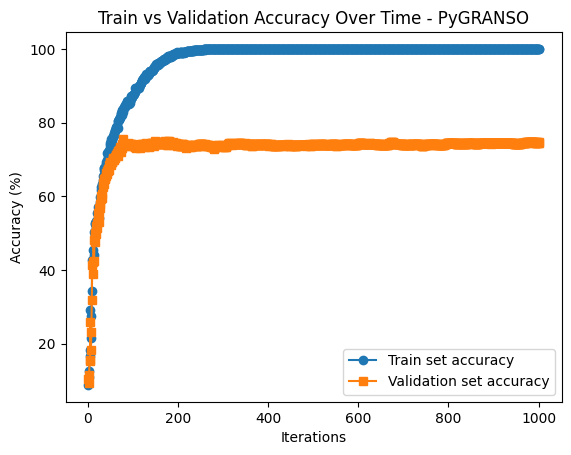

In [45]:
# Plot results
x = np.arange(1, len(train_acc)+1)

plt.plot(x, train_acc, label='Train set accuracy', marker='o')
plt.plot(x, test_acc, label='Validation set accuracy', marker='s')

plt.xlabel('Iterations')
plt.ylabel('Accuracy (%)')
plt.title('Train vs Validation Accuracy Over Time - PyGRANSO'.format(batch_size))

plt.legend()

plt.show()

In [46]:
def l2_penalty(model):
    A = list(model.parameters())[1]
    
    # print(A)
    
    return torch.norm(A.T @ A - torch.eye(hidden_size))

In [47]:
l2_penalty(model)

tensor(0.0005, dtype=torch.float64, grad_fn=<LinalgVectorNormBackward0>)

In [48]:
max(test_acc)

75.5859375